In [ ]:
# import pandas for data wrangling
import pandas as pd

# import numpy for Scientific computations
import numpy as np

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def clean_input_csv (url):
    df = pd.read_csv(url,na_values='.') # The na_values setting replaces NaN/null values with a floating-point and string compatible dot
    #df = df.sample(frac=1, random_state=1).reset_index() #okay actuall test train split already shuffles so this line is redundant

    # Change non-numerical columns to 'category' a statistical-category datatype understood by scikit,etc
    cols = df.select_dtypes(include='object').columns
    cols2=cols.drop(labels=['Support_Rana?'])
    #df[cols] = df[cols].fillna('MissingValues')
    
    #df[cols] = df[cols].astype('category')#change dtype
    df = df.drop(columns=cols2)

    # Remove columns that are due to contact with voters because that's a bias to prediction
    disallow=['mAddress','Address','PreferredEmail','VoterVolunteer','Volunteer_Ask','Notes','Heard_about_Rana?']
    df = df.drop(disallow, axis=1,errors='ignore')

    # Drop columns where y is null from test/train set
    df_after_dropping = df.dropna(axis='index',subset=['Support_Rana?'])
    needs_predictions = df[~df.index.isin(df_after_dropping.index)]
    df = df_after_dropping

    #Cleanup NaN/null in numeric columns
    # select numeric columns
    numeric_columns = df.select_dtypes(exclude=['category', 'object']).columns

    # fill 0 to all NaN 
    df[numeric_columns] = df[numeric_columns].fillna('0').apply(pd.to_numeric)

    # Split out the target column
    y = df['Support_Rana?'].str.replace('[^0-9]','').apply(pd.to_numeric).replace(2,1).replace(3,0).replace(4,0).replace(5,0).astype('int64')
    X = df.drop('Support_Rana?',axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    return X, y

In [ ]:
#csvs
url_all_ids_may10 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTMcVu8cf1ZEFK6yuHn3xgJrT5L5jTQa7GY9zuRaIvgyrYBpWL08iyAcvbWT9kyulrs1PT3u1HyrRGz/pub?gid=1976628524&single=true&output=csv'
url_all_phones_may3 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTd1WpzujmHh-qYe19ddQPSWFnrdmHM6g0XvblVcAVAVhwgM91qQKM4Hyvvi58fSnoGpjcWcXG3FSr6/pub?gid=616038225&single=true&output=csv'

# Import all phones may 3
X, y = clean_input_csv(url_all_phones_may3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'gamma': [1,.1,.01,10],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 400),
    'learning_rate': [0.05,.001],
    'scale_pos_weight': [1,1.3,2]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 4,
    verbose=True
)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 4 folds for each of 192 candidates, totalling 768 fits


XGBClassifier(gamma=0.01, learning_rate=0.05, max_depth=4, n_estimators=60,
              nthread=4, scale_pos_weight=1.3, seed=42)

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [ ]:
from sklearn.metrics import confusion_matrix

model=grid_search
predict = model.predict(X_test)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict)))
print(confusion_matrix(y_test,predict))

Best AUC Score: 0.6375414105768051
Accuracy: 0.6101190476190477
[[126  77]
 [ 54  79]]


In [ ]:
print(model.best_params_)


{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 60, 'scale_pos_weight': 1.3}


In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, predict, average='binary')

0.5064102564102564

0.6153846153846154

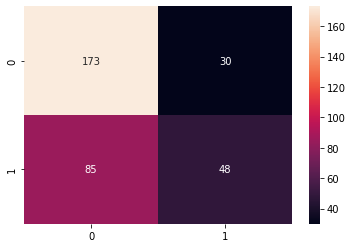

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier

# fit model no training data
#model = XGBClassifier()
#model.fit(X_train, y_train)

from sklearn.preprocessing import OrdinalEncoder
import numpy as np

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

model = make_pipeline(
    ordinal_encoder, XGBClassifier(random_state=45,
colsample_bylevel=0.3,
colsample_bytree=0.4,
gamma=0.01,
learning_rate=.003,
max_depth=1,
n_estimators=500,
subsample=0.8999999999999999,
scale_pos_weight=1)
)

model.fit(X_train, y_train)

predictions=model.predict(X_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

from sklearn.metrics import precision_score
precision_score(y_test, predictions, average='binary')